# 实时负载预测与资源管理 - 数据预处理

本笔记本专注于从用户视角进行负载预测的第一步：数据预处理。我们将使用Google集群数据集中的cluster_7数据。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. 数据加载与探索

In [2]:
# 读取 cluster_7 数据
data_path = '../../data/cluster_7.csv'
data_prefix = 'c7'
try:
    # 先读取少量数据以了解数据结构
    df_sample = pd.read_csv(data_path, nrows=1000)
    print(f"成功读取样本数据，形状: {df_sample.shape}")
    
    # 查看数据类型和基本信息
    display(df_sample.info())
    
    # 显示前几行数据
    display(df_sample.head())
    
    # 查看列名
    print("列名列表:")
    print(df_sample.columns.tolist())
    
except Exception as e:
    print(f"读取数据时出错: {e}")

成功读取样本数据，形状: (1000, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1000 non-null   int64  
 1   time                             1000 non-null   int64  
 2   instance_events_type             1000 non-null   int64  
 3   collection_id                    1000 non-null   int64  
 4   scheduling_class                 1000 non-null   int64  
 5   collection_type                  1000 non-null   int64  
 6   priority                         1000 non-null   int64  
 7   alloc_collection_id              1000 non-null   int64  
 8   instance_index                   1000 non-null   int64  
 9   machine_id                       1000 non-null   int64  
 10  resource_request                 995 non-null    object 
 11  constraint                       1000 non-null   object 
 1

None

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request,constraint,collections_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler,start_time,end_time,average_usage,maximum_usage,random_sample_usage,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0,2,94591244395,3,1,200,0,144,168846390496,"{'cpus': 0.020660400390625, 'memory': 0.014434...",[],2,fn8Ve4Tdl/FVVvwXFGIKe4+Wo4zLjUL/557qdFVYu5M=,Hzsv/gF8CPQXdqpsfovDTC1TJNyphDxPu7vaTeNxA74=,YCuhYrnORLiUh9WGL5q5tkBevfwtucSnFr2qPZh6Kes=,[],1.0,0.0,274800000000,275100000000,"{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356...","{'cpus': 0.0043487548828125, 'memory': None}",0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,"{'cpus': 0.00724029541015625, 'memory': 0.0013...",[],2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,hDGffcrF/rhQQEG8Uns/RMUK7R15DXjFnRasoKFhefI=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2.0,0.0,1800713000000,1800714000000,"{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': None}",0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,2,195684022913,6,276227177776,2,0,103,0,376,169321752432,"{'cpus': 0.048583984375, 'memory': 0.004165649...",[],6,/ivQBmewiFcXfGJdCUsEKx47NiRE29Tjiq3gw+zR2Cg=,kk6+maA6fvAdJ+VTU8AcpzQPTyVrx+ySt0MXRAyO8FU=,zCA2dl2PDptd82Hob906gE82JHzx0SbqA4mZurqZdmY=,[],2.0,1.0,81300000000,81600000000,"{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641...","{'cpus': 0.026458740234375, 'memory': None}",0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,6,130721370174,0,275444626052,1,0,117,0,13138,10129440520,"{'cpus': 0.00566864013671875, 'memory': 0.0015...",[{'name': '5dEuieuWMFy+CNMBBf/uXNX5nP4Kgzeu0O6...,0,jW2GJpOlCheoSzGcwfmRjkjV6mYZo4DC43ej/X/OyjM=,dofW6DHLUdjD9tYkZ/hat2bA6+e2GD+yBwbpmUgPLks=,Q+ko0Cb6Sy8WkHKRTMcgJQz2RhdSkBtrNnARybcK4k8=,[],1.0,0.0,343800000000,344100000000,"{'cpus': 0.0042572021484375, 'memory': 0.00131...","{'cpus': 0.012481689453125, 'memory': 0.001653...","{'cpus': 0.003154754638671875, 'memory': None}",0.002190,0.000006,0.646689,0.007937,1.0,[0.00023937 0.00050068 0.00242233 0.00288773 0...,[0.00743866 0.00748444 0.00752258 0.00760651 0...,7,ENABLE,0
4,7,2373350421416,3,193223725812,2,0,103,0,393,447672988,"{'cpus': 0.022003173828125, 'memory': 0.001501...",[],3,062wDMRDwqEvJU9SCE4WQ4ShulGBVG8WGeEcNoN23GA=,ZzY6C4/jBIeLrGNhYjEtwYJejtfAq9iSPeoA6gwV5Wg=,592j9ILjNCrNYFRzL91wGpX5mwQqY531R/tbmkwtYag=,[],2.0,1.0,455400000000,455700000000,"{'cpus': 0.0064697265625, 'memory': 0.00075817...","{'cpus': 0.027984619140625, 'memory': 0.000782...","{'cpus': 0.005615234375, 'memory': None}",0.001474,0.000059,1.767994,0.017505,1.0,[0.00054169 0.00374603 0.00450134 0.00513458 0...,[0.0098877 0.01011658 0.01023865 0.01055908 0...,7,FINISH,0


列名列表:
['Unnamed: 0', 'time', 'instance_events_type', 'collection_id', 'scheduling_class', 'collection_type', 'priority', 'alloc_collection_id', 'instance_index', 'machine_id', 'resource_request', 'constraint', 'collections_events_type', 'user', 'collection_name', 'collection_logical_name', 'start_after_collection_ids', 'vertical_scaling', 'scheduler', 'start_time', 'end_time', 'average_usage', 'maximum_usage', 'random_sample_usage', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'cpu_usage_distribution', 'tail_cpu_usage_distribution', 'cluster', 'event', 'failed']


## 2. 数据预处理

基于探索结果，我们将执行以下预处理步骤：
1. 转换时间格式
2. 选择与用户视角相关的特征
3. 处理缺失值
4. 数据规范化/标准化
5. 构建时间序列特征

In [3]:
# 读取完整数据（如果数据量太大，考虑使用chunk方式读取）
try:
    print("开始读取完整数据集...")
    # 读取前100万行数据用于初步分析（避免内存问题）
    # 实际应用中可能需要调整或使用流式处理
    df = pd.read_csv(data_path, nrows=1000000)
    print(f"成功读取数据，形状: {df.shape}")
except Exception as e:
    print(f"读取完整数据时出错: {e}")

开始读取完整数据集...
成功读取数据，形状: (50360, 34)


### 2.1 时间特征处理

In [4]:
# 处理时间特征
try:
    # 检查是否存在时间相关列
    time_columns = [col for col in df.columns if 'time' in col.lower()]
    print(f"时间相关列: {time_columns}")
    
    # 转换时间列格式
    # 注意：需要根据实际数据格式调整转换方法
    for col in time_columns:
        if col in df.columns:
            # 假设时间戳是微秒级别
            if df[col].dtype == 'int64' or df[col].dtype == 'float64':
                # 如果是unix时间戳格式
                df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
                print(f"转换列 {col} 为日期时间格式")
            else:
                # 尝试常规日期时间转换
                try:
                    df[f'{col}_dt'] = pd.to_datetime(df[col])
                    print(f"转换列 {col} 为日期时间格式")
                except:
                    print(f"无法转换列 {col} 为日期时间格式")
    
    # 显示转换后的时间列
    time_dt_columns = [col for col in df.columns if '_dt' in col]
    if time_dt_columns:
        display(df[time_dt_columns].head())
except Exception as e:
    print(f"处理时间特征时出错: {e}")

时间相关列: ['time', 'start_time', 'end_time']
转换列 time 为日期时间格式
转换列 start_time 为日期时间格式
转换列 end_time 为日期时间格式


,time_dt,start_time_dt,end_time_dt
0,1970-01-01 00:00:00.000000,1970-01-04 04:20:00,1970-01-04 04:25:00
1,1970-01-30 03:15:05.308183,1970-01-21 20:11:53,1970-01-21 20:11:54
2,1970-01-03 06:21:24.022913,1970-01-01 22:35:00,1970-01-01 22:40:00
3,1970-01-02 12:18:41.370174,1970-01-04 23:30:00,1970-01-04 23:35:00
4,1970-01-28 11:15:50.421416,1970-01-06 06:30:00,1970-01-06 06:35:00


### 2.2 选择用户视角相关特征

In [5]:
# 从用户视角选择相关特征
user_features = [
    # 用户标识
    'user',
    #'user', 'collection_id', 'collection_name', 'collection_logical_name',
    
    # 时间信息
    'time', 'time_dt', 'start_time', 'start_time_dt', 'end_time', 'end_time_dt',
    
    # 资源请求和使用
    'resource_request', 'average_usage', 'maximum_usage',
    #'cpu_usage_distribution', 'tail_cpu_usage_distribution',
    
    # 其他重要特征
    #'priority', 'instance_index', 'event', 'failed'
]

# 过滤实际存在的列
user_features = [col for col in user_features if col in df.columns]
print(f"选择的用户视角特征: {user_features}")

# 创建用户视角的数据子集
df_user = df[user_features].copy()
print(f"用户视角数据集形状: {df_user.shape}")
display(df_user.head())

选择的用户视角特征: ['user', 'time', 'time_dt', 'start_time', 'start_time_dt', 'end_time', 'end_time_dt', 'resource_request', 'average_usage', 'maximum_usage']
用户视角数据集形状: (50360, 10)


,user,time,time_dt,start_time,start_time_dt,end_time,end_time_dt,resource_request,average_usage,maximum_usage
0,fn8Ve4Tdl/FVVvwXFGIKe4+Wo4zLjUL/557qdFVYu5M=,0,1970-01-01 00:00:00.000000,274800000000,1970-01-04 04:20:00,275100000000,1970-01-04 04:25:00,"{'cpus': 0.020660400390625, 'memory': 0.014434...","{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356..."
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,2517305308183,1970-01-30 03:15:05.308183,1800713000000,1970-01-21 20:11:53,1800714000000,1970-01-21 20:11:54,"{'cpus': 0.00724029541015625, 'memory': 0.0013...","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}"
2,/ivQBmewiFcXfGJdCUsEKx47NiRE29Tjiq3gw+zR2Cg=,195684022913,1970-01-03 06:21:24.022913,81300000000,1970-01-01 22:35:00,81600000000,1970-01-01 22:40:00,"{'cpus': 0.048583984375, 'memory': 0.004165649...","{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641..."
3,jW2GJpOlCheoSzGcwfmRjkjV6mYZo4DC43ej/X/OyjM=,130721370174,1970-01-02 12:18:41.370174,343800000000,1970-01-04 23:30:00,344100000000,1970-01-04 23:35:00,"{'cpus': 0.00566864013671875, 'memory': 0.0015...","{'cpus': 0.0042572021484375, 'memory': 0.00131...","{'cpus': 0.012481689453125, 'memory': 0.001653..."
4,062wDMRDwqEvJU9SCE4WQ4ShulGBVG8WGeEcNoN23GA=,2373350421416,1970-01-28 11:15:50.421416,455400000000,1970-01-06 06:30:00,455700000000,1970-01-06 06:35:00,"{'cpus': 0.022003173828125, 'memory': 0.001501...","{'cpus': 0.0064697265625, 'memory': 0.00075817...","{'cpus': 0.027984619140625, 'memory': 0.000782..."


### 2.3 提取和处理资源使用信息

In [6]:
# 处理可能的非标准JSON格式
def extract_resource(x):
    if not isinstance(x, str):
        return np.nan, np.nan
    
    # 处理字典字符串格式
    try:
        # 尝试直接解析
        data = json.loads(x)
        return data.get('cpus', np.nan), data.get('memory', np.nan)
    except:
        # 如果不是标准JSON，尝试使用eval安全解析字典形式
        try:
            import ast
            data = ast.literal_eval(x)
            return data.get('cpus', np.nan), data.get('memory', np.nan)
        except:
            return np.nan, np.nan

# 处理资源请求和使用信息
try:
    # 检查资源列的格式
    resource_cols = ['resource_request', 'average_usage', 'maximum_usage']
    resource_cols = [col for col in resource_cols if col in df_user.columns]
    
    if resource_cols:
        display(df_user[resource_cols].head())
        
        # 假设资源列是JSON格式或具有特定结构的字符串
        for col in resource_cols:
            # 尝试提取CPU和内存信息
            try:
                # 示例：如果是JSON字符串形式
                if df_user[col].dtype == 'object':
                    # 尝试解析JSON
                    try:
                        import json
                        # 提取CPU和内存
                        # 应用提取函数
                        df_user[[f'{col}_cpu', f'{col}_memory']] = df_user[col].apply(extract_resource).apply(pd.Series)
                        print(f"从{col}中提取CPU和内存信息")
                    except:
                        print(f"无法从{col}中提取资源信息，可能需要检查数据格式")
            except Exception as e:
                print(f"处理{col}时出错: {e}")
    
    # 显示提取的资源信息
    extracted_cols = [col for col in df_user.columns if '_cpu' in col or '_memory' in col]
    if extracted_cols:
        display(df_user[extracted_cols].head())
except Exception as e:
    print(f"处理资源信息时出错: {e}")

,resource_request,average_usage,maximum_usage
0,"{'cpus': 0.020660400390625, 'memory': 0.014434...","{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356..."
1,"{'cpus': 0.00724029541015625, 'memory': 0.0013...","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}"
2,"{'cpus': 0.048583984375, 'memory': 0.004165649...","{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641..."
3,"{'cpus': 0.00566864013671875, 'memory': 0.0015...","{'cpus': 0.0042572021484375, 'memory': 0.00131...","{'cpus': 0.012481689453125, 'memory': 0.001653..."
4,"{'cpus': 0.022003173828125, 'memory': 0.001501...","{'cpus': 0.0064697265625, 'memory': 0.00075817...","{'cpus': 0.027984619140625, 'memory': 0.000782..."


从resource_request中提取CPU和内存信息
从average_usage中提取CPU和内存信息
从maximum_usage中提取CPU和内存信息


,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
0,0.020660,0.014435,0.004662,5.920410e-03,0.011902,5.935669e-03
1,0.007240,0.001303,0.000000,9.536743e-07,0.000000,9.536743e-07
2,0.048584,0.004166,0.024200,2.788544e-03,0.060059,2.845764e-03
3,0.005669,0.001562,0.004257,1.316071e-03,0.012482,1.653671e-03
4,0.022003,0.001501,0.006470,7.581711e-04,0.027985,7.820129e-04


### 2.4 处理缺失值

In [7]:
# 检查缺失值
missing_values = df_user.isnull().sum()
missing_percentage = (missing_values / len(df_user)) * 100

missing_df = pd.DataFrame({
    '缺失值数量': missing_values,
    '缺失百分比': missing_percentage
}).sort_values('缺失百分比', ascending=False)

display(missing_df[missing_df['缺失值数量'] > 0])

# 处理缺失值
# 方法1：移除缺失值过多的列
threshold = 50  # 50%缺失率阈值
columns_to_drop = missing_df[missing_df['缺失百分比'] > threshold].index.tolist()
if columns_to_drop:
    print(f"移除缺失值过多的列: {columns_to_drop}")
    df_user = df_user.drop(columns=columns_to_drop)

# 方法2：用特定值填充缺失值
# 数值型列用0或均值填充
numeric_cols = df_user.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df_user[col].isnull().sum() > 0:
        # 使用0填充
        df_user[col] = df_user[col].fillna(0)
        print(f"用0填充{col}的缺失值")

# 分类列用最频繁值填充
categorical_cols = df_user.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_user[col].isnull().sum() > 0:
        # 使用最频繁值填充
        most_frequent = df_user[col].mode()[0]
        df_user[col] = df_user[col].fillna(most_frequent)
        print(f"用最频繁值'{most_frequent}'填充{col}的缺失值")

# 检查处理后的缺失值
missing_after = df_user.isnull().sum()
if missing_after.sum() > 0:
    print("处理后仍有缺失值的列:")
    display(missing_after[missing_after > 0])
else:
    print("所有缺失值已处理")

,缺失值数量,缺失百分比
maximum_usage_memory,1943,3.858221
resource_request,140,0.277998
resource_request_cpu,140,0.277998
resource_request_memory,140,0.277998


用0填充resource_request_cpu的缺失值
用0填充resource_request_memory的缺失值
用0填充maximum_usage_memory的缺失值
用最频繁值'{'cpus': 0.0111541748046875, 'memory': 0.0013027191162109375}'填充resource_request的缺失值
所有缺失值已处理


In [8]:
df_user

,user,time,time_dt,start_time,start_time_dt,end_time,end_time_dt,resource_request,average_usage,maximum_usage,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
0,fn8Ve4Tdl/FVVvwXFGIKe4+Wo4zLjUL/557qdFVYu5M=,0,1970-01-01 00:00:00.000000,274800000000,1970-01-04 04:20:00,275100000000,1970-01-04 04:25:00,"{'cpus': 0.020660400390625, 'memory': 0.014434...","{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356...",0.020660,0.014435,0.004662,5.920410e-03,0.011902,5.935669e-03
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,2517305308183,1970-01-30 03:15:05.308183,1800713000000,1970-01-21 20:11:53,1800714000000,1970-01-21 20:11:54,"{'cpus': 0.00724029541015625, 'memory': 0.0013...","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}",0.007240,0.001303,0.000000,9.536743e-07,0.000000,9.536743e-07
2,/ivQBmewiFcXfGJdCUsEKx47NiRE29Tjiq3gw+zR2Cg=,195684022913,1970-01-03 06:21:24.022913,81300000000,1970-01-01 22:35:00,81600000000,1970-01-01 22:40:00,"{'cpus': 0.048583984375, 'memory': 0.004165649...","{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641...",0.048584,0.004166,0.024200,2.788544e-03,0.060059,2.845764e-03
3,jW2GJpOlCheoSzGcwfmRjkjV6mYZo4DC43ej/X/OyjM=,130721370174,1970-01-02 12:18:41.370174,343800000000,1970-01-04 23:30:00,344100000000,1970-01-04 23:35:00,"{'cpus': 0.00566864013671875, 'memory': 0.0015...","{'cpus': 0.0042572021484375, 'memory': 0.00131...","{'cpus': 0.012481689453125, 'memory': 0.001653...",0.005669,0.001562,0.004257,1.316071e-03,0.012482,1.653671e-03
4,062wDMRDwqEvJU9SCE4WQ4ShulGBVG8WGeEcNoN23GA=,2373350421416,1970-01-28 11:15:50.421416,455400000000,1970-01-06 06:30:00,455700000000,1970-01-06 06:35:00,"{'cpus': 0.022003173828125, 'memory': 0.001501...","{'cpus': 0.0064697265625, 'memory': 0.00075817...","{'cpus': 0.027984619140625, 'memory': 0.000782...",0.022003,0.001501,0.006470,7.581711e-04,0.027985,7.820129e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50355,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,30866788727,1970-01-01 08:34:26.788727,2475300000000,1970-01-29 15:35:00,2475600000000,1970-01-29 15:40:00,"{'cpus': 0.00310516357421875, 'memory': 0.0013...","{'cpus': 0.011505126953125, 'memory': 0.006629...","{'cpus': 0.04901123046875, 'memory': 0.0099639...",0.003105,0.001303,0.011505,6.629944e-03,0.049011,9.963989e-03
50356,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1868418340318,1970-01-22 15:00:18.340318,1793470000000,1970-01-21 18:11:10,1793475000000,1970-01-21 18:11:15,"{'cpus': 0.02166748046875, 'memory': 0.0013027...","{'cpus': 0.00011730194091796875, 'memory': 1.9...","{'cpus': 0.0005846023559570312, 'memory': 1.90...",0.021667,0.001303,0.000117,1.907349e-06,0.000585,1.907349e-06
50357,jW2GJpOlCheoSzGcwfmRjkjV6mYZo4DC43ej/X/OyjM=,439744167717,1970-01-06 02:09:04.167717,343800000000,1970-01-04 23:30:00,344100000000,1970-01-04 23:35:00,"{'cpus': 0.00566864013671875, 'memory': 0.0015...","{'cpus': 0.0042572021484375, 'memory': 0.00131...","{'cpus': 0.012481689453125, 'memory': 0.001653...",0.005669,0.001562,0.004257,1.316071e-03,0.012482,1.653671e-03
50358,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1660973826390,1970-01-20 05:22:53.826390,25800000000,1970-01-01 07:10:00,26100000000,1970-01-01 07:15:00,"{'cpus': 0.0111541748046875, 'memory': 0.00130...","{'cpus': 0.0006113052368164062, 'memory': 0.00...","{'cpus': 0.001392364501953125, 'memory': 0.005...",0.011154,0.001303,0.000611,5.287170e-03,0.001392,5.294800e-03


### 2.5 构建用户级别的时间序列特征

In [9]:
# 用户级别的时间序列聚合
try:
    # 确保存在用户ID和时间特征
    if 'user' in df_user.columns and 'time_dt' in df_user.columns:
        # 按用户ID和时间对资源使用进行聚合
        ## 先确定要聚合的资源列
        #resource_features = [col for col in df_user.columns 
        #            if ('_cpu' in col or '_memory' in col) 
        #            and not ('distribution' in col)]
        
        #if resource_features:
            # 确定时间粒度（例如小时级别）
            df_user['hour'] = df_user['time_dt'].dt.floor('h')

            # 按用户和时间聚合资源使用的修改版本
            print("按用户和时间聚合资源使用...")

            ## 创建自定义聚合字典
            #agg_dict = {}
            #for col in resource_features:
            #    # 对每列既保留原值(first)又计算统计量
            #    agg_dict[col] = ['first', 'mean', 'max', 'min', 'std']

            ## 使用自定义聚合方式
            #user_hourly = df_user.groupby(['user', 'hour']).agg(agg_dict)

            ## 整理列名
            #user_hourly.columns = [f"{col[0]}{'_'+col[1] if col[1]!='first' else ''}" for col in user_hourly.columns]

            ## 重置索引
            #user_hourly = user_hourly.reset_index()
            user_hourly = df_user.groupby(['user', 'time_dt']).first().reset_index()
            print(f"用户小时级别聚合数据形状: {user_hourly.shape}")
            display(user_hourly.head())
        #else:
        #    print("无法找到资源特征列，请先处理资源信息")
    else:
        print("缺少必要的用户ID或时间特征")
except Exception as e:
    print(f"构建时间序列特征时出错: {e}")

按用户和时间聚合资源使用...
用户小时级别聚合数据形状: (42917, 17)


,user,time_dt,time,start_time,start_time_dt,end_time,end_time_dt,resource_request,average_usage,maximum_usage,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour
0,+52peVL4nAGr4mgVjZQpkJDhArvSYmdIoludPEovCFU=,1970-01-01 00:00:00.000000,0,2303700000000,1970-01-27 15:55:00,2304000000000,1970-01-27 16:00:00,"{'cpus': 0.0501708984375, 'memory': 0.01092529...","{'cpus': 0.025604248046875, 'memory': 0.008392...","{'cpus': 0.1082763671875, 'memory': 0.00845336...",0.050171,0.010925,0.025604,0.008392,0.108276,0.008453,1970-01-01 00:00:00
1,+52peVL4nAGr4mgVjZQpkJDhArvSYmdIoludPEovCFU=,1970-01-29 09:39:38.964265,2453978964265,1165200000000,1970-01-14 11:40:00,1165500000000,1970-01-14 11:45:00,"{'cpus': 0.0501708984375, 'memory': 0.01081848...","{'cpus': 0.028289794921875, 'memory': 0.008087...","{'cpus': 0.0821533203125, 'memory': 0.00822448...",0.050171,0.010818,0.028290,0.008087,0.082153,0.008224,1970-01-29 09:00:00
2,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,1970-01-01 00:00:00.000000,0,185077000000,1970-01-03 03:24:37,185080000000,1970-01-03 03:24:40,"{'cpus': 0.00188446044921875, 'memory': 0.0002...","{'cpus': 0.00024509429931640625, 'memory': 0.0...","{'cpus': 0.00063323974609375, 'memory': 0.0002...",0.001884,0.000213,0.000245,0.000122,0.000633,0.000205,1970-01-01 00:00:00
3,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,1970-01-01 00:20:49.456152,1249456152,253886000000,1970-01-03 22:31:26,253887000000,1970-01-03 22:31:27,"{'cpus': 0.0012454986572265625, 'memory': 0.00...","{'cpus': 0.0, 'memory': 9.5367431640625e-06}","{'cpus': 0.0, 'memory': 9.5367431640625e-06}",0.001245,0.000211,0.000000,0.000010,0.000000,0.000010,1970-01-01 00:00:00
4,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,1970-01-01 00:49:06.196299,2946196299,253886000000,1970-01-03 22:31:26,253887000000,1970-01-03 22:31:27,"{'cpus': 0.0012454986572265625, 'memory': 0.00...","{'cpus': 0.0, 'memory': 9.5367431640625e-06}","{'cpus': 0.0, 'memory': 9.5367431640625e-06}",0.001245,0.000211,0.000000,0.000010,0.000000,0.000010,1970-01-01 00:00:00


In [10]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50360 entries, 0 to 50359
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user                     50360 non-null  object        
 1   time                     50360 non-null  int64         
 2   time_dt                  50360 non-null  datetime64[ns]
 3   start_time               50360 non-null  int64         
 4   start_time_dt            50360 non-null  datetime64[ns]
 5   end_time                 50360 non-null  int64         
 6   end_time_dt              50360 non-null  datetime64[ns]
 7   resource_request         50360 non-null  object        
 8   average_usage            50360 non-null  object        
 9   maximum_usage            50360 non-null  object        
 10  resource_request_cpu     50360 non-null  float64       
 11  resource_request_memory  50360 non-null  float64       
 12  average_usage_cpu        50360 n

### 2.6 标准化/归一化数值特征(因为数据已经通过归一化处理了，此处不需要这个过程)

### 2.7 保存处理后的数据

In [11]:
# 处理用户ID中的非法文件名字符
def clean_user_id(user_id):
    # 定义允许用于文件名的字符集
    valid_chars = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    # 只保留有效字符
    clean_chars = [c for c in user_id if c in valid_chars]
    
    # 取前7个有效字符(如果有)
    short_id = ''.join(clean_chars[:7])
    
    # 如果没有有效字符,使用"user"作为默认值
    if not short_id:
        short_id = "user"
    
    ## 添加哈希的最后4位以确保唯一性(避免截短后出现重复)
    #if len(user_id) > 4:
    #    suffix = user_id[-4:]
    #else:
    #    import hashlib
    #    suffix = hashlib.md5(user_id.encode()).hexdigest()[:4]
    
    return f"{short_id}"

qualified_users = 0
target_qualified = 50  # 目标合格用户数
max_users_to_check = 50000 # 最多检查的用户数
minimum_data_length = 300

# 保存处理后的数据
try:
    # 创建输出目录
    output_dir = "../processed_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"创建输出目录: {output_dir}")
    
    # 计算每个用户的资源使用变异程度
    user_variability = user_hourly.groupby('user')[['average_usage_cpu', 'average_usage_memory']].std()

    # 添加变异系数(标准差/均值)以更好比较
    user_means = user_hourly.groupby('user')[['average_usage_cpu', 'average_usage_memory']].mean()
    user_variability['cv_cpu'] = user_variability['average_usage_cpu'] / user_means['average_usage_cpu']
    user_variability['cv_memory'] = user_variability['average_usage_memory'] / user_means['average_usage_memory']

    for i, user in enumerate(user_variability.sort_values('cv_cpu', ascending=False).index):
        # 超过检查上限则退出
        if i >= max_users_to_check:
            break

        # 清理用户ID
        clean_id = clean_user_id(user)

        # 获取并保存数据
        user_data = user_hourly[user_hourly['user'] == user].sort_values('time_dt')
        # 检查数据量是否足够
        if len(user_data) >= minimum_data_length:
            # 数据量充足,保存文件

            cols_to_exclude = ['time', 'start_time', 'end_time', 'resource_request', 'average_usage' ,'maximum_usage']
            user_data = user_data.drop(columns=[col for col in cols_to_exclude if col in user_data.columns])

            user_data.to_csv(f'../processed_data/{data_prefix}_user_{clean_id}_timeseries.csv', index=False)
            print(f"保存用户{user}的时间序列数据,共{len(user_data)}条记录,文件名为user_{clean_id}_timeseries.csv")
            qualified_users += 1
            
            # 找到足够多的合格用户后退出
            if qualified_users >= target_qualified:
                print(f"已找到{target_qualified}个数据量充足的用户,处理完成")
                break
        else:
            # 数据量不足,跳过保存
            print(f"用户{user}的数据量不足({len(user_data)}条<{minimum_data_length}条),跳过保存")

except Exception as e:
    print(f"保存数据时出错: {e}")

保存用户fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=的时间序列数据,共2215条记录,文件名为user_fxHzmdZ_timeseries.csv
保存用户+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=的时间序列数据,共415条记录,文件名为user_czwEXtt_timeseries.csv
保存用户DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=的时间序列数据,共24348条记录,文件名为user_DrrEIEW_timeseries.csv
用户i6S3M1T5pgDZudDtuzVvszN6245Ur5ekAmHlLzcZVz8=的数据量不足(2条<300条),跳过保存
保存用户QXNirTL84KUsi2ZGntOYA15Vauoi90aLnLoh/zXK7AY=的时间序列数据,共380条记录,文件名为user_QXNirTL_timeseries.csv
用户v6En8sOonA8oxPW/HzjnfFOmOAX3iYTxEgkHhwtxnkA=的数据量不足(5条<300条),跳过保存
保存用户77mZ3/L7TctcF6oWAVyFUZQq1H79EJ1Qfv/YjTz5mW8=的时间序列数据,共1618条记录,文件名为user_77mZ3L7_timeseries.csv
保存用户ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=的时间序列数据,共4920条记录,文件名为user_ly4HE4d_timeseries.csv
用户NgIIcJjsEUMkllP/nf1jU921JL9GNrFJiOFheNntcRw=的数据量不足(24条<300条),跳过保存
保存用户jW2GJpOlCheoSzGcwfmRjkjV6mYZo4DC43ej/X/OyjM=的时间序列数据,共2440条记录,文件名为user_jW2GJpO_timeseries.csv
用户90P5pnzFfhJeTbcIDOA3aw3CPdc2CimYMNcpYJE+VCo=的数据量不足(279条<300条),跳过保存
用户EJ6g9LG8XDDPqG0XLB4Gq1k1U9kQQyqVlYEfRnWAQlE=的数据量不

## 3. 数据探索与可视化

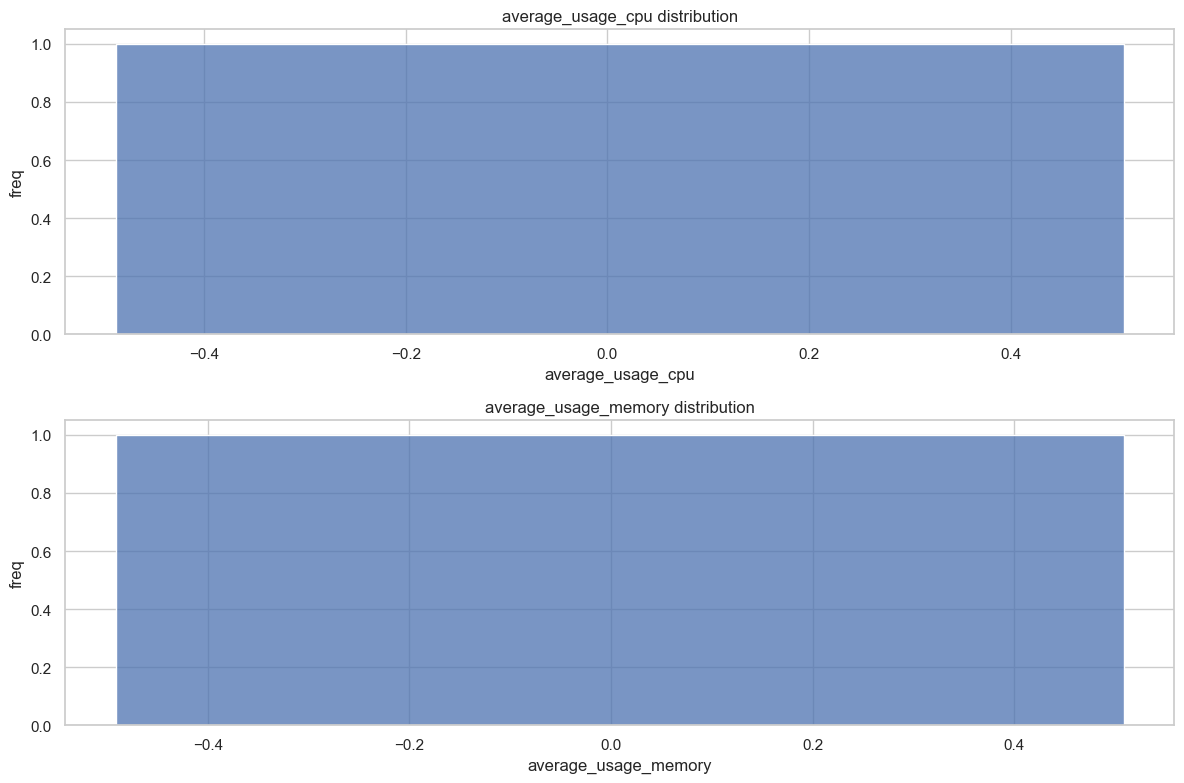

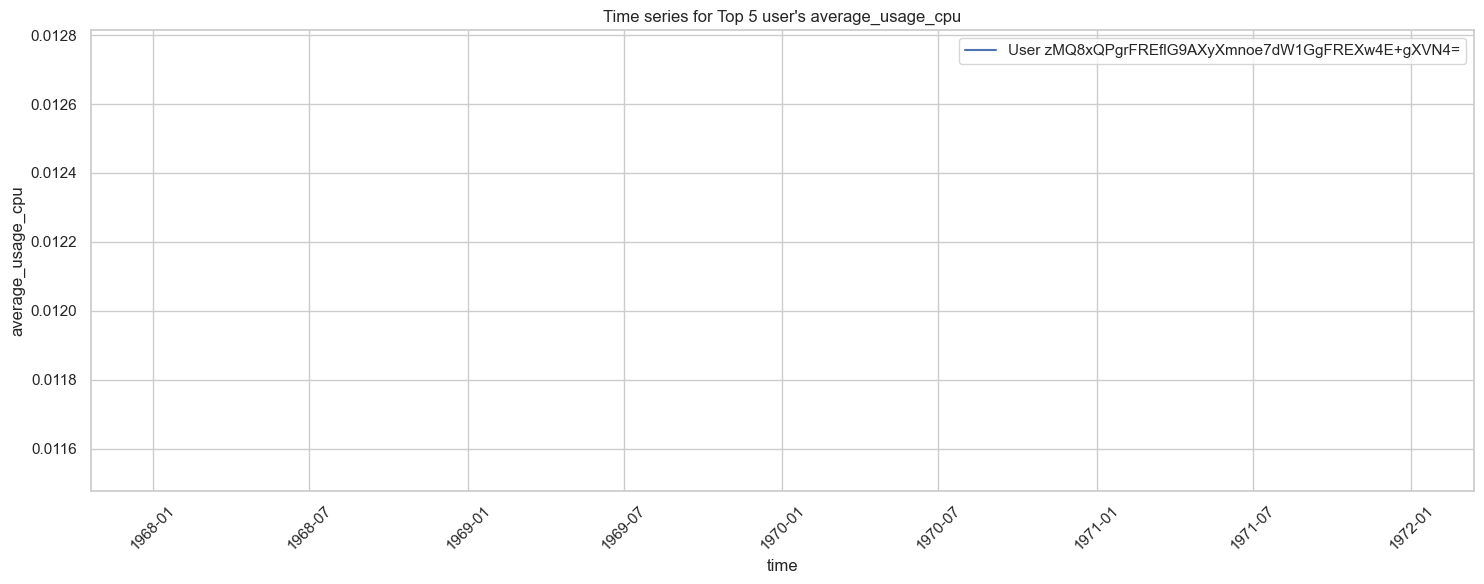

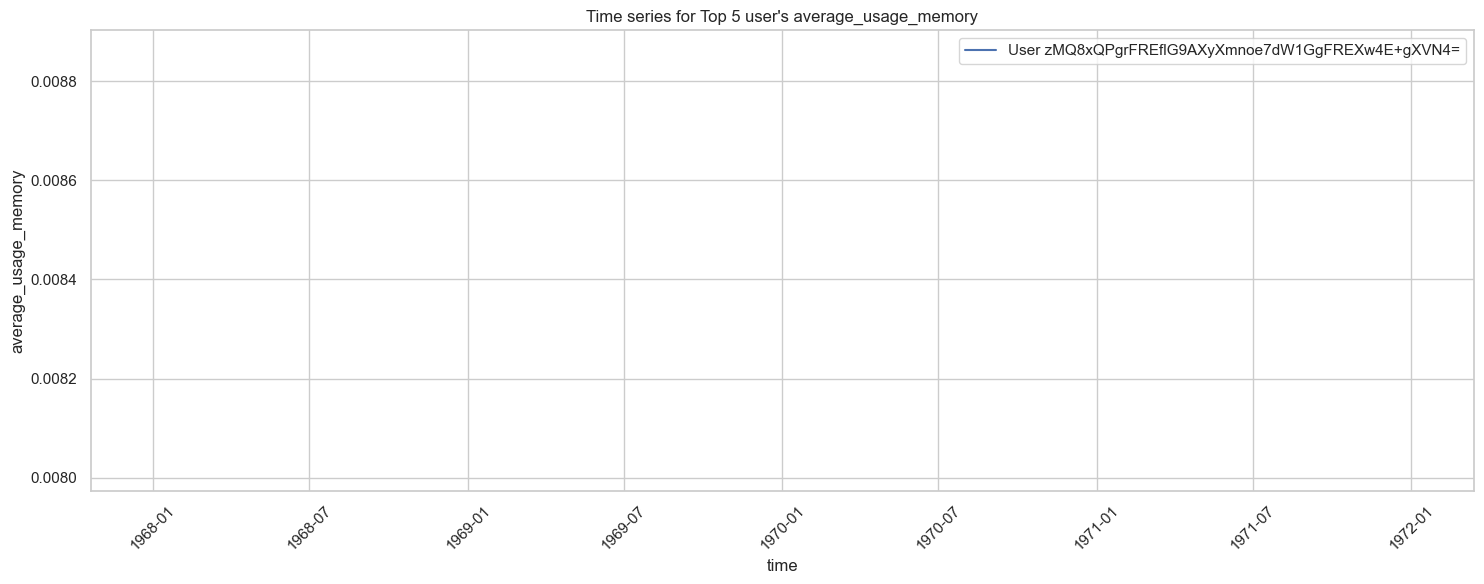

In [12]:
# 可视化用户资源使用分布
try:
    if 'user_data' in locals():
        # 选择一些关键特征进行可视化
        #key_features = [col for col in user_hourly.columns if '_mean' in col][:4]  # 选择前4个均值特征
        key_features = [col for col in ['average_usage_cpu', 'average_usage_memory']] 
        if key_features:
            fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
            if len(key_features) == 1:
                axes = [axes]
                
            for i, feature in enumerate(key_features):
                sns.histplot(user_data[feature], ax=axes[i])
                axes[i].set_title(f'{feature} distribution')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('freq')
            
            plt.tight_layout()
            plt.show()
            
            # 选择前5个用户，查看其资源使用时间序列
            top_users = user_data['user'].value_counts().nlargest(5).index
            
            for feature in key_features:
                plt.figure(figsize=(15, 6))
                for user in top_users:
                    user_data = user_data[user_data['user'] == user]
                    if not user_data.empty:
                        plt.plot(user_data['hour'], user_data[feature], label=f'User {user}')
                
                #plt.title(f'Top 5 用户的 {feature} 时间序列')
                plt.title(f"Time series for Top 5 user's {feature}")
                plt.xlabel('time')
                plt.ylabel(feature)
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    else:
        print("没有找到用户时间序列数据进行可视化")
except Exception as e:
    print(f"数据可视化时出错: {e}")

## 4. 总结与下一步

在这个笔记本中，我们完成了以下工作：
1. 加载并探索了cluster_7的数据
2. 处理了时间特征
3. 提取了用户视角的关键特征
4. 处理了资源使用信息
5. 处理了缺失值
6. 构建了用户级别的时间序列特征
7. 标准化了数值特征
8. 可视化了关键资源使用模式

下一步：
1. 基于处理后的数据构建时间序列预测模型
2. 评估不同模型的预测性能
3. 进行特征重要性分析
4. 将预测结果与实际资源使用进行比较分析